# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [84]:
def make_system(beta1, gamma1, beta2, gamma2, t_b, pop):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init1 = State(S=(pop-1), I1=1, R1=0, I2=0, R2=0, Iboth=0, I12=0, I21=0, Rboth=0)
    seriesS = TimeSeries()
    seriesI = TimeSeries()
    seriesR = TimeSeries()
    #S: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #Iboth: num people infected by both diseases
    #I12: num people recovered from disease A and got disease B
    #I21: num people recovered from disease B and got disease A
    #Rboth: num people who recovered from both diseases
    #seriesS: total num people susceptible 
    #seriesI: total num people infected
    #seriesR: total num people who recovered 
    
    init1 /= np.sum(init1)

    t0 = 0
    t_end = 7 * 14 * 2
    t_b = t_b
    #print(t_b)

    return System(init1=init1, t0=t0, t_end=t_end, t_b = t_b, pop = pop, seriesS=seriesS, seriesI=seriesI, seriesR=seriesR,
                  beta1=beta1, gamma1=gamma1, beta2=beta2, gamma2=gamma2, intersect_t=0, intersect=1)

In [3]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    return system.seriesS[system.t0] - system.seriesS[system.t_end]

In [4]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's an updated version of `run_simulation` that uses `unpack`.

In [5]:
def run_simulation(system):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init1.index)
    frame.loc[t0] = init1
    seriesS[t0] = init1.S
    seriesI[t0] = init1.I1
    seriesR[t0] = init1.R1
    
    for i in linrange(t0, t_end):
        if i < t_b:
            frame.loc[i+1] = update1(frame.loc[i], system, i)
        else:
            frame.loc[i+1] = update2(frame.loc[i], system, i)

    system.results = frame

In [6]:
def update1(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state

    infected1 = beta1 * i1 * s    
    recovered1 = gamma1 * i1
    
    s -= infected1
    i1 += infected1 - recovered1
    r1 += recovered1
    
    seriesS[i] = s 
    seriesI[i] = i1 
    seriesR[i] = r1 #since there is only one disease, people who recovered from it are in the recovered category
    
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

In [81]:
def update2(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state
    
    beta1offset1 = beta1 + beta1/100
    beta1offset2 = beta1 - beta1/100
    beta2offset1 = beta2 + beta2/100
    beta2offset2 = beta2 - beta2/100
    
    gamma1offset1 = gamma1 + gamma1/100
    gamma1offset2 = gamma1 - gamma1/100
    gamma2offset1 = gamma2 + gamma2/100
    gamma2offset2 = gamma2 - gamma2/100
    
#     beta1offset1 = beta1
#     beta1offset2 = beta1
#     beta2offset1 = beta2
#     beta2offset2 = beta2
    
#     gamma1offset1 = gamma1 
#     gamma1offset2 = gamma1 
#     gamma2offset1 = gamma2
#     gamma2offset2 = gamma2 
    
    if i == t_b:
        #at time t)b, we still have SIR model continuing for disease A with the addition of a fraction of the population infected by disease B
        infected1 = beta1 * i1 * s    
        recovered1 = gamma1 * i1
        infected2 = 10/pop
        s -= (infected1 + infected2) 
        i2 += infected2
        i1 += (infected1 - recovered1)
        r1 += recovered1
        seriesS[i] = s + r1
        seriesI[i] = i1 + i2 
        seriesR[i] = rboth
        return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)
    
    infected1 = beta1*s*i1
    infected2 = beta2*s*i2
    recovered1 = gamma1*i1
    recovered2 = gamma2*i2
    infected1b = beta2offset1*i1*i2
    infected2b = beta1offset1*i1*i2
    infected12 = (beta2offset2*r1*(i2+iboth))
    infected21 = (beta1offset2*r2*(i1+iboth))
    recoveredbb = ((1/((1/gamma1)+(1/gamma2)))*iboth)
    recovered2b = gamma2offset1*i12
    recovered1b = gamma1offset1*i21
    
    s = s - (infected1 + infected2)
    if s < 0:
        s = 0
    
    i1 = i1 + infected1 - recovered1 - infected1b
    if i1 < 0:
        i1 = 0
        
    i2 = i2 + infected2 - recovered2 - infected2b
    if i2 < 0:
        i2 = 0
        
    iboth = iboth + infected1b + infected2b - recoveredbb
    if iboth < 0:
        iboth = 0
    
    r1 = r1 + recovered1 - infected12
    if r1 < 0:
        r1 = 0
    
    r2 = r2 + recovered2 - infected21
    if r2 < 0:
        r2 = 0
        
    i12 = i12 + infected12 - recovered2b
    if i12 < 0:
        i12 = 0
    
    i21 = i21 + infected21 - recovered1b
    if i21 < 0:
        i21 = 0
        
    rboth = rboth + recovered2b + recovered1b
    if rboth < 0:
        rboth = 0
        
#     if rboth > s and system.intersect == 1:
#         system.intersect_t = i
#         system.intersect = 0
        #print("intersect", system.intersect_t)
    
    if rboth > 0.5 and system.intersect == 1:
        system.intersect_t = i
        system.intersect = 0
        print("intersect", system.intersect_t)
    
    seriesS[i] = s + r1 + r2
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = rboth
    
    #if seriesS[i] + seriesI[i] + seriesR[i] != 1:
       # print("something is wrong at ", i)
       # print(seriesS[i] + seriesI[i] + seriesR[i])
        
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

Test the updated code with this example.

In [82]:
tc1 = 3
tr1 = 6
tc2 = 2
tr2 = 8
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
system = make_system(beta1, gamma1, beta2, gamma2, 30, 90)
run_simulation(system)
system.results = system.results.dropna()
print(system.results)

intersect 98.0
            S            I1        R1            I2       R2         Iboth  \
0    0.988889  1.111111e-02  0.000000  0.000000e+00  0.00000  0.000000e+00   
1    0.985226  1.292181e-02  0.001852  0.000000e+00  0.00000  0.000000e+00   
2    0.980983  1.501181e-02  0.004005  0.000000e+00  0.00000  0.000000e+00   
3    0.976074  1.741862e-02  0.006507  0.000000e+00  0.00000  0.000000e+00   
4    0.970407  2.018280e-02  0.009411  0.000000e+00  0.00000  0.000000e+00   
5    0.963878  2.334751e-02  0.012774  0.000000e+00  0.00000  0.000000e+00   
6    0.956377  2.695764e-02  0.016666  0.000000e+00  0.00000  0.000000e+00   
7    0.947783  3.105859e-02  0.021159  0.000000e+00  0.00000  0.000000e+00   
8    0.937971  3.569443e-02  0.026335  0.000000e+00  0.00000  0.000000e+00   
9    0.926810  4.090546e-02  0.032284  0.000000e+00  0.00000  0.000000e+00   
10   0.914173  4.672509e-02  0.039102  0.000000e+00  0.00000  0.000000e+00   
11   0.899935  5.317585e-02  0.046889  0.000000e+

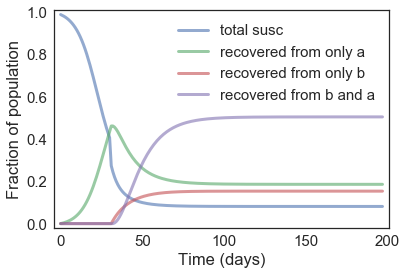

In [25]:
frame = system.results
plot(frame.S, label='total susc')
plot(frame.R1, label='recovered from only a')
plot(frame.R2, label='recovered from only b')
plot(frame.Rboth, label="recovered from b and a")
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')
#plot_results(system.seriesS, system.seriesI, system.seriesR)

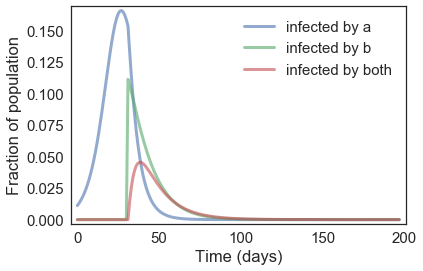

In [26]:
plot(frame.I1, label='infected by a')
plot(frame.I2, label='infected by b')
plot(frame.Iboth, label='infected by both')
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

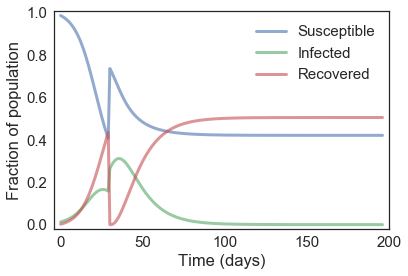

In [27]:
plot(system.seriesS, label='Susceptible')
plot(system.seriesI, label='Infected')
plot(system.seriesR, label='Recovered')
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [93]:
t_b_array = linrange(15, 35, 1)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    sweep[t_b] = system.intersect_t
    print(system.intersect_t)

0
0
0
0
0
0
0
intersect 88.0
88.0
intersect 81.0
81.0
intersect 79.0
79.0
intersect 79.0
79.0
intersect 79.0
79.0
intersect 81.0
81.0
intersect 84.0
84.0
intersect 89.0
89.0
intersect 98.0
98.0
0
0
0
0
0


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


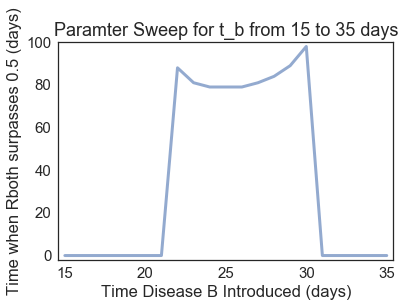

In [95]:
plot(sweep)
decorate(xlabel='Time Disease B Introduced (days)',
         ylabel='Time when Rboth surpasses 0.5 (days)', title='Paramter Sweep for t_b from 15 to 35 days')